In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] ="" 
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline


C:\Users\mudda\anaconda3\envs\tf_gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
nepochs=10
im_height, im_width = 224, 224  ## Image input resolution
ratios= [0.6,0.2,0.2]  # data split percentage between main model, rasp1 model and rasp2 model
data_dir='./brain_tumour_dataset/'

In [4]:

  #[0.6,0.2,0.2] works well
format_list=['*.jpg', '*.JPG', '*.jpeg','*.png'];

### Get all files
yes_files=[glob.glob(data_dir+'yes/'+e) for e in format_list]
yes_files = pd.DataFrame({'filename':[item for sublist in yes_files for item in sublist]})
label_yes=np.ones(len(yes_files))

no_files=[glob.glob(data_dir+'no/'+e) for e in format_list]
no_files = pd.DataFrame({'filename':[item for sublist in no_files for item in sublist]})
label_no=np.zeros(len(no_files))

print(f'Total yes files {len(yes_files)}')
print(f'Total no files {len(no_files)}')

all_files=pd.concat([yes_files,no_files])
all_labels=np.concatenate((label_yes,label_no),axis=0)

#spliting data in some ratios
rasp_files,main_files,rasp_labels, main_labels=train_test_split(all_files,all_labels,test_size=ratios[0],train_size=ratios[1]+ratios[2], stratify=all_labels, random_state=52)
rasp1_files,rasp2_files, rasp1_labels,rasp2_labels=train_test_split(rasp_files,rasp_labels,test_size=ratios[1]/(ratios[1]+ratios[2]),train_size=ratios[2]/(ratios[1]+ratios[2]), stratify=rasp_labels, random_state=52)

print(len(all_files))
print(f' Main files:  {len(main_files)}')
print(len(rasp_files))
print(f' rasp1 files:  {len(rasp1_files)}')
print(f' rasp2 files:  {len(rasp2_files)}')


#exporting to csv file
main_files['labels']=main_labels
main_files.to_csv(data_dir+'main_data.csv',index=False)

rasp1_files['labels']=rasp1_labels
rasp1_files.to_csv(data_dir+'rasp1_data.csv',index=False)

rasp2_files['labels']=rasp2_labels
rasp2_files.to_csv(data_dir+'rasp2_data.csv',index=False)


Total yes files 309
Total no files 189
498
 Main files:  299
199
 rasp1 files:  99
 rasp2 files:  100


(6, 224, 224, 3) (6,)


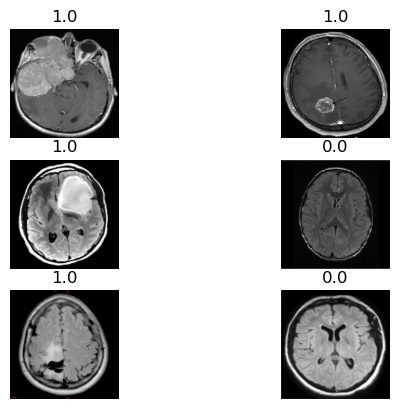

In [5]:

from tensorflow.keras import layers

class BrainTumorDataset(tf.keras.utils.Sequence):
    def __init__(self, df,
                 batch_size,
                 input_size=(224, 224, 3),
                 shuffle=True, do_augmentation=False):
        
        self.df = df
        self.batch_size=batch_size
        self.input_size=input_size
        self.do_augmentation=do_augmentation
        if do_augmentation:  ## We need to augment only the training data here.
            self.data_augmentation = tf.keras.Sequential([
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(0.2),
                ])

            self.replicate_factor=12
        else:
            self.replicate_factor=1

        self.max_index=len(self.df)//self.batch_size
    
    def on_epoch_end(self):
        pass
    
    def load_image(self,name):
        image= tf.keras.preprocessing.image.load_img(name)
        image= tf.keras.preprocessing.image.img_to_array(image)
        image= tf.image.resize(image,(self.input_size[0],self.input_size[1]))
        if self.do_augmentation: # and np.random.rand(1)<0.2:   #0.2 propbality the augmentation happens, we don't want distort all the imagews
            image=self.data_augmentation(image)
        return image

    def __getitem__(self, index):
        index=index%self.max_index
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        images=[]
        labels=[]
        for index, row in batches.iterrows():
          images.append(self.load_image(row['filename']))
          labels.append(row['labels'])
        return np.array(images),np.array(labels)
    
    def __len__(self):
        return len(self.df)*self.replicate_factor // self.batch_size
        
####### Plot sample data for verification
dataframe=pd.read_csv('./brain_tumour_dataset/rasp1_data.csv')
sample_data=BrainTumorDataset(dataframe,6,input_size=(im_height, im_width,3))
ims,labs=sample_data.__getitem__(0)

print(ims.shape,labs.shape)

for j in range(ims.shape[0]):
  plt.subplot(3,2,j+1)
  plt.imshow(ims[j,:,:,:]/255.)
  plt.title(labs[j])
  plt.axis('off')

plt.show()

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
###### Function to Get the Model

def GetModel(type='simple',im_height=224,im_width=224, compile=True):
    tf.keras.backend.reset_uids()
    if type=='simple':
        model = Sequential([
          layers.Rescaling(1./255, input_shape=(im_height, im_width, 3)),
          layers.Conv2D(8, 3, padding='valid', activation='relu',name='cnn1'),
          layers.MaxPooling2D(),
          layers.Conv2D(16, 3, padding='valid', activation='relu',name='cnn2'),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='valid', activation='relu',name='cnn3'),
          layers.MaxPooling2D(),
          layers.Flatten(),
          layers.Dense(32, activation='relu',name='dense1'),
          layers.Dense(1,name='dense2')
        ])
    elif type=='extra_dense_cnn':
        model = Sequential([
          layers.Rescaling(1./255, input_shape=(im_height, im_width, 3)),
          layers.Conv2D(8, 3, padding='valid', activation='relu',name='cnn1',trainable=False),
          layers.MaxPooling2D(),
          layers.Conv2D(16, 3, padding='valid', activation='relu',name='cnn2',trainable=False),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='valid', activation='relu',name='cnn3',trainable=False),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='same', activation='relu',name='cnn4',trainable=True),
          layers.Flatten(),
          layers.Dense(32, activation='relu',name='dense1'),
          layers.Dense(32, activation='relu',name='dense_post'),
          layers.Dense(1,name='dense2')
        ])
    else:
      raise 'Model type is not correct'
    if compile:
      model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
    model.summary()
    return model
# model_1=GetModel()
# for layer in model_1.layers:
#   print(layer.name)


In [7]:
model=GetModel(im_height=im_height,im_width=im_width)
df=pd.read_csv('./brain_tumour_dataset/main_data.csv')  ## Get the main model training data and labels
train,vals=train_test_split(df,train_size=0.8, stratify=df['labels'],random_state=42)

train_ds= BrainTumorDataset(train,8,input_size=(im_height, im_width,3), do_augmentation=True) ## Create the train and validation data generators.
val_ds =  BrainTumorDataset(vals,1,input_size=(im_height, im_width,3))
history = model.fit(train_ds,validation_data=val_ds,epochs=nepochs) ## Train the main from random init and store the model for later use
model.save_weights('./checkpoints/main_model/model')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 cnn1 (Conv2D)               (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 cnn2 (Conv2D)               (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 cnn3 (Conv2D)               (None, 52, 52, 32)        4

In [8]:
loss_rasp1, accuracy_rasp1=model.evaluate(val_ds,batch_size=1)
print(f'Accuracy of main trained model on unseen data {accuracy_rasp1*100}%')

60/60 [==============================] - 1s 11ms/step - loss: 1.6641 - accuracy: 0.8667
Accuracy of main trained model on unseen data 86.66666746139526%


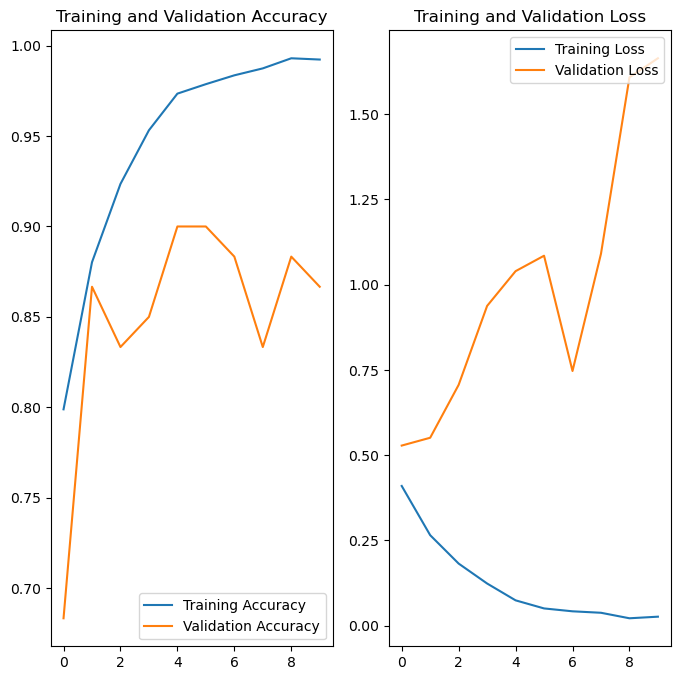

In [9]:

#Took from https://www.tensorflow.org/tutorials/images/classification
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(nepochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
